In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np

data = pd.read_csv("preprocessed_apartment_rentals_no_state_dummies_nocluster.csv")

# Features und Ziel
X = data.drop(columns=["price"])
y = data["price"]
#y = np.log1p(y)  # Log-Transformation


# Regression

# Ridge Regression

In [2]:
from Nested_CV_targetEncoding import NestedCVRegressorWithTargetEncoding

In [3]:
from sklearn.linear_model import Ridge
import numpy as np
from sklearn.preprocessing import StandardScaler
ridge_params = {"alpha": np.logspace(-3, 3, 10)}

ridge_cv = NestedCVRegressorWithTargetEncoding(model = Ridge(), param_grid = ridge_params, encode_cols=["state", "cityname"], scaler = StandardScaler)
ridge_cv.run(X, y, output=True, log_transform=False)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Outer Fold 1/5 | Best Params: {'model__alpha': np.float64(215.44346900318823)} | Fit Time: 0.251s | Outer R²: 0.683 | MSE: 149791.288
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Outer Fold 2/5 | Best Params: {'model__alpha': np.float64(215.44346900318823)} | Fit Time: 0.289s | Outer R²: 0.679 | MSE: 148808.129
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Outer Fold 3/5 | Best Params: {'model__alpha': np.float64(215.44346900318823)} | Fit Time: 0.188s | Outer R²: 0.680 | MSE: 148919.442
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Outer Fold 4/5 | Best Params: {'model__alpha': np.float64(215.44346900318823)} | Fit Time: 0.347s | Outer R²: 0.670 | MSE: 152997.177
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Outer Fold 5/5 | Best Params: {'model__alpha': np.float64(215.44346900318823)} | Fit Time: 0.219s | Outer R²: 0.680 | MSE: 148662.294


In [ ]:
number_outer_cv_splits = 5
model_evaluation = pd.DataFrame({"Fold": range(1, number_outer_cv_splits+1)})
model_evaluation['Modell'] = ['Ridge_TE'] * number_outer_cv_splits
model_evaluation['R_2'] = ridge_cv.get_r2_scores()
model_evaluation['MSE'] = ridge_cv.get_mse_scores()
model_evaluation["runtime"] = ridge_cv.get_fit_times()
model_evaluation

,Fold,Modell,R_2,MSE,runtime
0,1,Ridge_TE_y_transformed,0.683233,149791.287819,0.251265
1,2,Ridge_TE_y_transformed,0.679134,148808.129076,0.288623
2,3,Ridge_TE_y_transformed,0.680093,148919.442087,0.188109
3,4,Ridge_TE_y_transformed,0.670328,152997.176541,0.346958
4,5,Ridge_TE_y_transformed,0.679876,148662.294147,0.219012


In [5]:
#model_evaluation.to_pickle('benchmarking/Ridgeregression_targetencoding_y_log_transformed.pkl')

-----------------------------------------------------------------------------
Jetzt mit Log-Transformation

In [8]:
y = np.log1p(y)  # Log-Transformation
ridge_params = {"alpha": np.logspace(-3, 3, 10)}

ridge_cv = NestedCVRegressorWithTargetEncoding(model = Ridge(), param_grid = ridge_params, encode_cols=["state", "cityname"], scaler = StandardScaler)
ridge_cv.run(X, y, output=True, log_transform=True)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Outer Fold 1/5 | Best Params: {'model__alpha': np.float64(215.44346900318823)} | Fit Time: 0.292s | Outer R²: 0.691 | MSE: 146171.761
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Outer Fold 2/5 | Best Params: {'model__alpha': np.float64(215.44346900318823)} | Fit Time: 0.275s | Outer R²: 0.683 | MSE: 146810.995
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Outer Fold 3/5 | Best Params: {'model__alpha': np.float64(215.44346900318823)} | Fit Time: 0.297s | Outer R²: 0.681 | MSE: 148682.195
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Outer Fold 4/5 | Best Params: {'model__alpha': np.float64(215.44346900318823)} | Fit Time: 0.213s | Outer R²: 0.675 | MSE: 150946.071
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Outer Fold 5/5 | Best Params: {'model__alpha': np.float64(215.44346900318823)} | Fit Time: 0.338s | Outer R²: 0.683 | MSE: 147221.959


In [9]:
number_outer_cv_splits = 5
model_evaluation = pd.DataFrame({"Fold": range(1, number_outer_cv_splits+1)})
model_evaluation['Modell'] = ['Ridge_TE_log_transformed'] * number_outer_cv_splits
model_evaluation['R_2'] = ridge_cv.get_r2_scores()
model_evaluation['MSE'] = ridge_cv.get_mse_scores()
model_evaluation["runtime"] = ridge_cv.get_fit_times()
model_evaluation

,Fold,Modell,R_2,MSE,runtime
0,1,Ridge_TE_log_transformed,0.690887,146171.761027,0.292073
1,2,Ridge_TE_log_transformed,0.683441,146810.994714,0.275138
2,3,Ridge_TE_log_transformed,0.680602,148682.195329,0.296504
3,4,Ridge_TE_log_transformed,0.674748,150946.070551,0.213256
4,5,Ridge_TE_log_transformed,0.682978,147221.959362,0.337716


# Lasso

In [7]:
from sklearn.linear_model import Lasso
import numpy as np
lasso_params = {"alpha": np.logspace(-3, 3, 10)}

lasso_cv = NestedCVRegressorWithTargetEncoding(model = Lasso(), param_grid = lasso_params, encode_cols=["state", "cityname"])
lasso_cv.run(X, y, output=True)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


KeyboardInterrupt: 

# Analyse
Welche Preise werden gut, welche schlechter vorhergesagt?

Final Alpha: 215.44346900318823
Test MSE: 146426.753945318
Test R²: 0.6847298249529536


C:\Users\User\AppData\Local\Temp\ipykernel_32212\2933609623.py:71: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


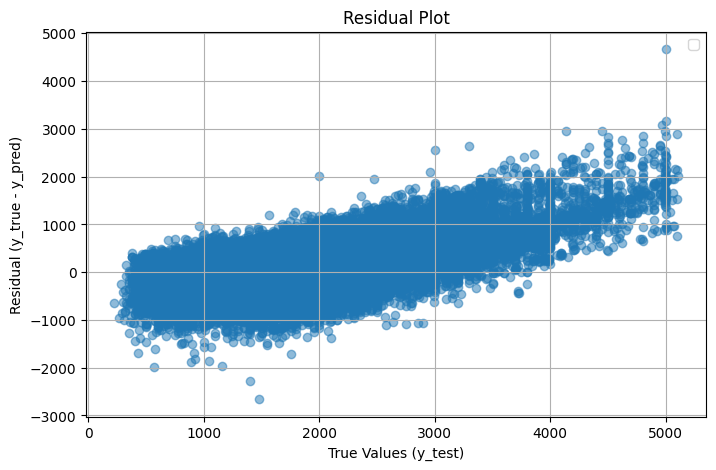

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from category_encoders import TargetEncoder

# ---------------------------------------------------------
# 1️⃣ Finales Alpha aus Nested CV (von dir vorher berechnet)
# ---------------------------------------------------------
best_parameters = ridge_cv.get_best_params()   # liefert Liste von dicts

alpha_values = [float(list(p.values())[0]) for p in best_parameters]
final_alpha = np.median(alpha_values)
print("Final Alpha:", final_alpha)

# ---------------------------------------------------------
# 2️⃣ Train/Test Split
# ---------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


# ---------------------------------------------------------
# 3️⃣ Target Encoding korrekt (nur auf TRAIN fitten!)
# ---------------------------------------------------------
te = TargetEncoder(cols=["state", "cityname"])   # deine kategorische Spalte

# Auf TRAIN fitten
te.fit(X_train[["state", "cityname"]], y_train)

# Transformieren
X_train_enc = X_train.copy()
X_test_enc = X_test.copy()

X_train_enc[["cityname", "state"]] = te.transform(X_train[["cityname", "state"]])
X_test_enc[["cityname", "state"]] = te.transform(X_test[["cityname", "state"]])

# ---------------------------------------------------------
# 4️⃣ Finales Ridge-Modell trainieren
# ---------------------------------------------------------
final_model = Ridge(alpha=final_alpha)
final_model.fit(X_train_enc, y_train)

# ---------------------------------------------------------
# 5️⃣ Vorhersagen + Scores
# ---------------------------------------------------------
y_pred = final_model.predict(X_train_enc)

mse = mean_squared_error(y_train, y_pred)
r2 = r2_score(y_train, y_pred)

print("Test MSE:", mse)
print("Test R²:", r2)

# ---------------------------------------------------------
# 6️⃣ Residual Plot (Residuals oder Absolute Error)
# ---------------------------------------------------------
residuals = y_train - y_pred
abs_error = np.abs(y_train - y_pred)

plt.figure(figsize=(8,5))
scatter = plt.scatter(y_train, residuals, 
                      alpha=0.5)
plt.xlabel("True Values (y_test)")
plt.ylabel("Residual (y_true - y_pred)")
plt.title("Residual Plot")
plt.grid(True)
#plt.hist(y_test, bins = 50, alpha=0.3, label='y_test', color='red')
plt.legend()
plt.show()

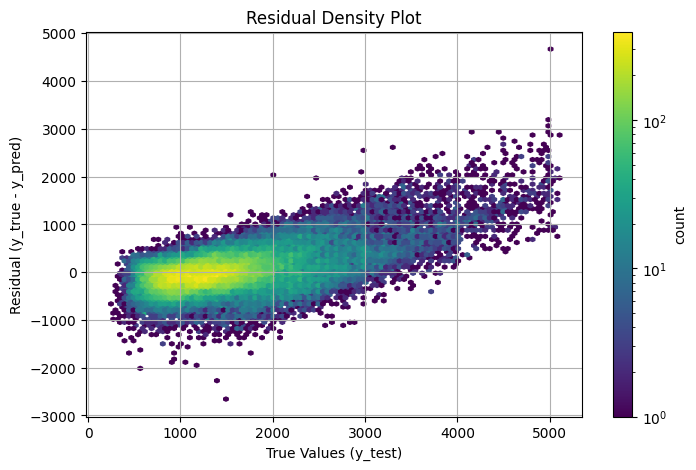

In [ ]:
plt.figure(figsize=(8, 5))

hb = plt.hexbin(
    y_train,
    residuals,
    bins="log"
)

plt.xlabel("True Values (y_test)")
plt.ylabel("Residual (y_true - y_pred)")
plt.title("Residual Density Plot")
plt.grid(True)

cb = plt.colorbar(hb)
cb.set_label("count")

plt.show()


## Feature Importance

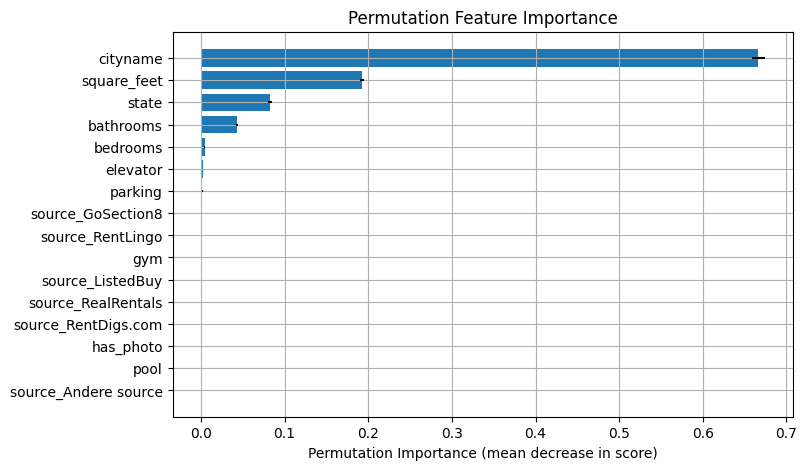

,feature,importance_mean,importance_std
10,source_Andere source,-0.000017,0.000010
6,pool,-0.000015,0.000045
2,has_photo,0.000100,0.000036
14,source_RentDigs.com,0.000237,0.000084
13,source_RealRentals,0.000254,0.000052
12,source_ListedBuy,0.000962,0.000163
7,gym,0.001070,0.000203
15,source_RentLingo,0.001226,0.000138
11,source_GoSection8,0.001289,0.000264
8,parking,0.001814,0.000093


In [ ]:
from sklearn.model_selection import train_test_split
import permutation_importance_
from sklearn.linear_model import Ridge
import category_encoders as ce
from sklearn.pipeline import Pipeline

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

rows_to_encode = ["cityname", "state"]

target_encoder = ce.TargetEncoder(
    cols=rows_to_encode,
    smoothing=10
)

#Final Ridge Model
best_parameters = ridge_cv.get_best_params()   # liefert Liste von dicts
alpha_values = [float(list(p.values())[0]) for p in best_parameters]
final_alpha = np.median(alpha_values)
final_ridge = Ridge(alpha=final_alpha)

model_pipeline = Pipeline([
    ("target_encoding", target_encoder),
    ("scaler", StandardScaler()),
    ("model", final_ridge)
])
model_pipeline.fit(X_train, y_train)

permutation_importance_.permutation_importance_analysis(model_pipeline, X_val, y_val, save_as_pkl=True, file_name="Ridge.pkl", show_plot=True)

In [ ]:
ridge_model = model_pipeline.named_steps["model"]
coef = ridge_model.coef_
intercept = ridge_model.intercept_
feature_names = X_train.columns

coef_df = pd.DataFrame({
    "feature": feature_names,
    "coefficient": coef
}).sort_values("coefficient", key=np.abs, ascending=False)
print(coef_df)


                 feature  coefficient
4               cityname   396.404067
3            square_feet   207.833901
5                  state   138.358535
0              bathrooms    98.375340
1               bedrooms   -35.758011
9               elevator    24.535134
8                parking    20.679074
11     source_GoSection8   -20.572976
15      source_RentLingo    19.566847
12      source_ListedBuy   -16.093319
7                    gym    14.621809
14   source_RentDigs.com   -10.061860
13    source_RealRentals     7.758985
6                   pool    -4.444731
2              has_photo     3.581459
10  source_Andere source     0.700063
